<a href="https://colab.research.google.com/github/barrytl/CE6003/blob/master/Etivity_assignment1_20197772_BarryLawton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etivity Assignment 1: Ships in Satellite Imagery
In this assignment we will build & train an object detector to solve the problem of idenifying ships in satellite imagery. 

![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/sat_img1.JPG?raw=true)

This assignment demonstrates that classical image processing techniques may be used in preference to deep learning for certain applications. Particularly those that are limited in computational power or require fast execution. 



This lab uses a [kaggle dataset](https://www.kaggle.com/rhammell/ships-in-satellite-imagery). Please read the [PDF](https://github.com/tonyscan6003/CE6003/blob/master/images/CE6003_kaggle_data_instructions.pdf) detailing how to setup your PC so that you can use a kaggle dataset within Colab.  The dataset contains image patches of ships as well as background images of sea and coastline. 

![Ships in Satellite imagery](https://i.imgur.com/tLsSoTz.png)

This assigment contains all the code necessary to read the downloaded kaggle files and create image and label arrays with test and train splits.




# Dowload Kaggle Dataset.
The following code cells will download the kaggle ship-in-satellite-imagery dataset and unzip the file. (Ensure you have a valid kaggle API token stored on your PC as described in the PDF.)

In [3]:

! pip install -q kaggle==1.5.6
from google.colab import files
files.upload()

     |████████████████████████████████| 58 kB 3.2 MB/s 


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"barrylawton","key":"e632aeebf1ae458f16204da09c8b4cbb"}'}

In [4]:
# Use this only if have problems with stale .json file
#!rm kaggle.json
#!rm ~/.kaggle/kaggle.*

In [5]:
#Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
#Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/
#Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

# Load dataset
! kaggle datasets download rhammell/ships-in-satellite-imagery

!unzip ships-in-satellite-imagery.zip > /dev/null

 99% 183M/185M [00:02<00:00, 114MB/s] 
100% 185M/185M [00:02<00:00, 71.7MB/s]


#HouseKeeping
 Import packages, helper functions to read from URL and import images.

In [6]:

from skimage import feature
from skimage import exposure
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import glob
import urllib.request
import cv2
import matplotlib.pyplot as plt


def url_to_image(url):
  	resp = urllib.request.urlopen(url)
  	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
  	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
  	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
  	return temp_image

def read_image(image_url):
    image = url_to_image(image_url)
    x,y,z = np.shape(image)
    # Image is scaled to reduce computation time
    image = cv2.resize(image, dsize=(int(y/sf), int(x/sf)), interpolation=cv2.INTER_CUBIC)
    return image

In [7]:
# Read downloaded file list: Files are comprised of positive (ship) and negaitive (Not ship) examples

pos_img_list = glob.glob('shipsnet/shipsnet/1_*.png')
neg_img_list = glob.glob('shipsnet/shipsnet/0_*.png')
print(np.shape(pos_img_list))
print(np.shape(neg_img_list))

(1000,)
(3000,)


# Read Data 
Read data from unzipped downloaded files and create the Training and Test sets. (Note that these are training and test sets of image patches that can be used to train an image classifier)

In [8]:
# Set variables
n = 80 # number of x,y pixels in this image.
n_pts = 4000 # number of points to use (are 4000 in dataset, 1000 positive 3000 negative)

In [9]:


def read_images(img_list):
   train_pos = np.empty([1,n*n])
   # Function to read images from file list 
   for i in range(len(img_list)): 
      img_path = img_list[i]
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #  store image as row in array
      train_pos = (np.concatenate((train_pos,np.reshape(img, (1, n*n)))) if i>0 else  np.reshape(img, (1, n*n)))
   return train_pos 

In [10]:
# Read positive and negative shp images into arrays 
pos_img = read_images(pos_img_list)

neg_img = read_images(neg_img_list)


In [11]:
# create corresponding arrays of labels
y_pos_labels = np.ones(len(pos_img_list))
y_neg_labels = np.zeros(len(neg_img_list))

In [12]:
# Combine positive and negative images into one dataset. 
dataset_img = np.concatenate((pos_img[0:1000,:],neg_img[0:3000,:]))
dataset_labels = np.append(y_pos_labels,y_neg_labels)

In [13]:
# Training examples
n_train = int(0.7*n_pts)

# Divide into training and test sets with labels
X_train, X_test, y_train, y_test = train_test_split(dataset_img, dataset_labels, train_size=n_train,
                                                    random_state=0,
                                                    stratify=dataset_labels)


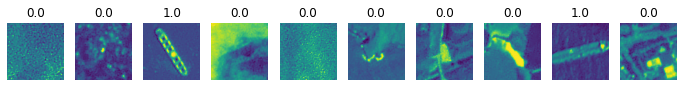

In [14]:
# Plot some examples from the training data
n_plots = 10 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(12,20))
for i in range(0,n_plots,1):

   axarr[i].imshow( np.reshape(X_train[i,0:n*n], (n, n))) # ,'gray'
   axarr[i].axis('off')
   axarr[i].title.set_text(y_train[i])



#Part 2. Build and Train an Image Classifier
As we have seen in the notes simple object detectors are based on image classifiers trained on image patches. You must choose an appropriate representation for the images and a suitable classifier.

Hints:
> `feature.hog` command from [skimage](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html). 

>sklearn [list of classifiers](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)



## Your Work Here......
You can write code to train and test your image classifier in the code cell(s) below:

In [15]:
image_1 = np.reshape(X_train[8,0:n*n],(n,n))

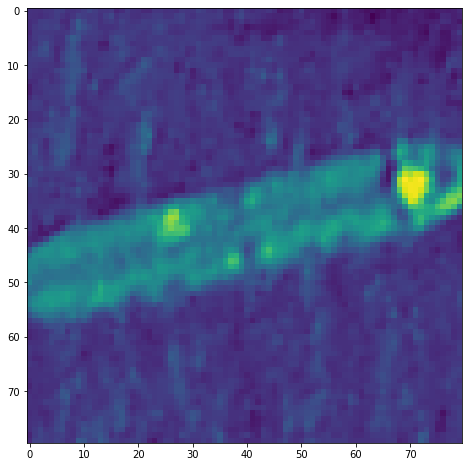

In [16]:
plt.figure(figsize=(8,8))
plt.imshow(image_1)
plt.show()

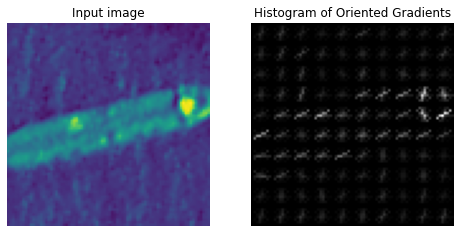

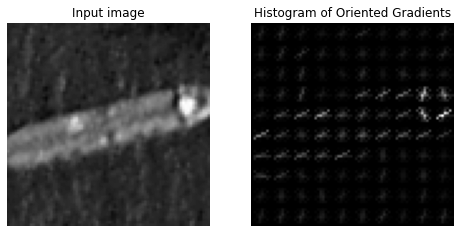

In [17]:
# Rough work
# Comparison plots showing difference between Histogram of Orientated Gradients with different parameters

import matplotlib.pyplot as plt

sample_image = np.reshape(X_train[8,0:n*n],(n,n))

fd, hog_image = feature.hog(sample_image, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2,2),transform_sqrt=True, block_norm='L1', visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(sample_image)#, cmap=plt.cm)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10),out_range=(0,255))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


fd, hog_image =  feature.hog(sample_image, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(3,3), block_norm='L2-Hys', visualize=True) #transform_sqrt=True

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(sample_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image)

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [62]:
def image_hog(image_, orientations_ = 9, pixels_per_cell_=(8, 8),cells_per_block_=(2, 2), visualize_=True):
  """
  Function to generate Histogram of Gradients and produce a visualisation for an image
  """

  hist, hog_image = feature.hog(image_, orientations = orientations_, pixels_per_cell=pixels_per_cell_, cells_per_block=cells_per_block_,
                transform_sqrt =True,block_norm = 'L2-Hys' , visualize=visualize_)
  

  return hist, hog_image_rescaled

In [19]:
X_train_hog = []
X_train_hog_visual = []
for i in range(len(X_train)):
  image = np.reshape(X_train[i,0:n*n],(n,n))
  X_train_hog.append(image_hog(image)[0])

In [20]:
X_test_hog = []
X_test_hog_visual= []
for i in range(len(X_test)):
  image = np.reshape(X_test[i,0:n*n],(n,n))
  X_test_hog.append(image_hog(image)[0])

In [21]:
y_train.shape

(2800,)

In [22]:
# Train a SVM classifier using GridSearch to find the optimal parameters
from sklearn.model_selection import GridSearchCV

parameter_grid = {
    'C' : [1,10,100],
    'gamma' : [1, 0.1, 0.01],
    'kernel' : ['rbf']
}
search = GridSearchCV(svm.SVC(), parameter_grid, n_jobs=-1)
search.fit(X_train_hog,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [23]:
search.best_score_

0.9782142857142857

In [24]:
search.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [25]:
classifier_model  = search.best_estimator_

In [26]:
classifier_model.fit(X_train_hog, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [27]:
y_pred =  classifier_model.predict(X_test_hog)

Test performance of your classifier using the test dataset and obtain a [classification report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report).

You can plot some examples from the test set using the function in the cell below.  

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       900
         1.0       0.95      0.97      0.96       300

    accuracy                           0.98      1200
   macro avg       0.97      0.98      0.97      1200
weighted avg       0.98      0.98      0.98      1200



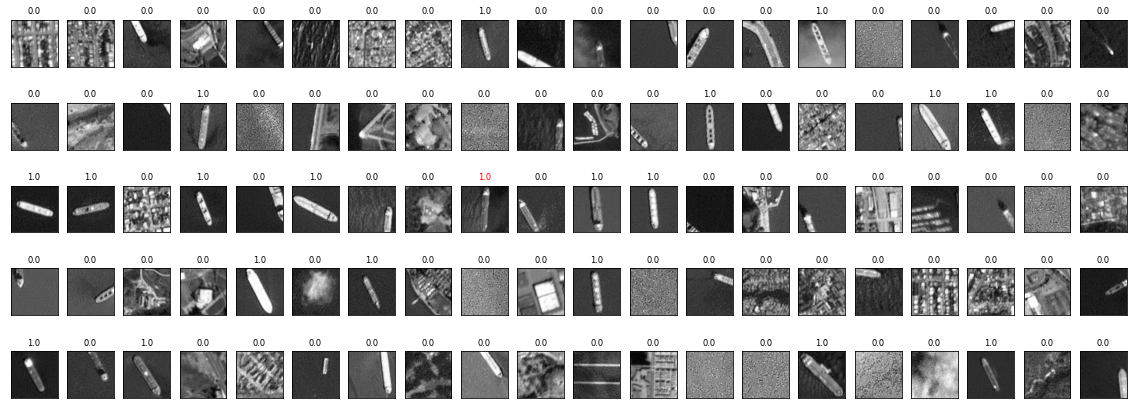

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

def plot_examples(y_pred,y_test):
   n_plots = 30 # number of plots
   fig = plt.figure(figsize=(20, 15))
   for i in range(100):
      ax = fig.add_subplot(10, 20, i + 1, xticks=[], yticks=[])
      ax.imshow( np.reshape(X_test[i,0:n*n], (n, n)) ,'gray')
      color = ('black' if y_pred[i] == y_test[i] else 'red')
      ax.set_title(y_test[i],
                 fontsize='small', color=color)
      
plot_examples(y_pred,y_test) 

# 2. Use the Classifier as a basic Object Detector 

**Import scene:** We want to use the classifier to perform object detection of ships in the high resolution satellite image scene imported in the code cell below. You can use grey scale version of the image gray_img in your detector, bounding boxes marking the locations of the ships can be applied to the colour version of the image.

*Coordinate Systems*

> The greyscale input image that we are applying our sliding window detector to is a matrix. The elements of this matrix are accessed as (row,column). In order to successfully plot the bouding box using OpenCV rectangle commands, the bounding boxes must be output in a format [x1,y1,x2,y2] where x1,y1 correspond to the top left hand side corner of the bouding box and x2,y2 the bottom right corner. Thus the x coordinate of the bounding box corresponds to the column of the matrix and the y coordinate the rows. The origin (0,0) in the coordinate system used by OpenCV is the top left of the image.

*Non Maximal Supression*

>  We can use the `non_max_supression` function from the `imutils` package to remove overlapping detections. (This is already implemented in a spearate code cell (see below) that displays the bouding boxes you find)  






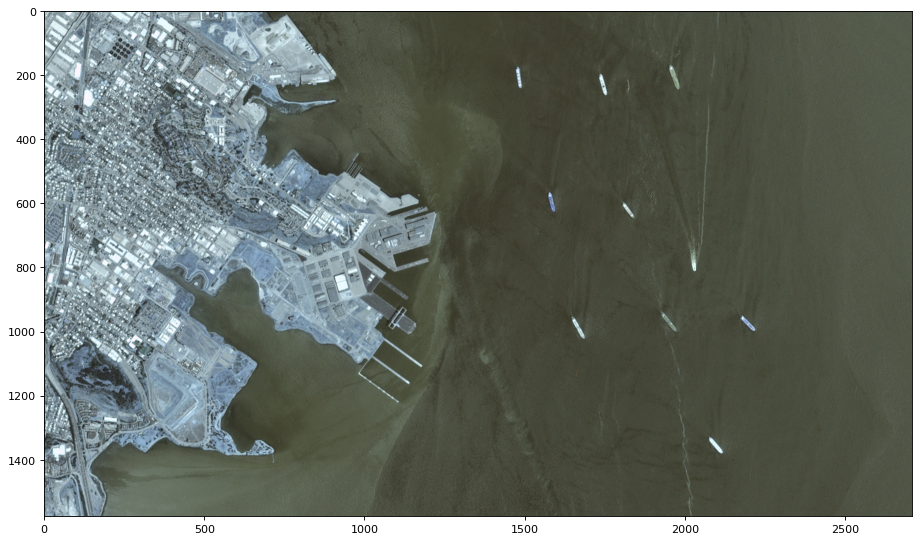

In [29]:
# Load and Display Secene to perform Object Detection on
img_path = 'scenes/scenes/sfbay_3.png'
col_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
gray_img = cv2.cvtColor(col_img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(col_img, aspect='auto') 
plt.imshow( col_img ,'gray')






## Your Work Here......
You can write code for the object detector that uses the classifier you previously developed in the code cell below:

The output of your object detector should be an array called "found_boxes" that is m x 4 array of output bounding boxes.
Each row corresponds to a bounding box [x1,y2,x2,y2] (see note on coordinate system above)








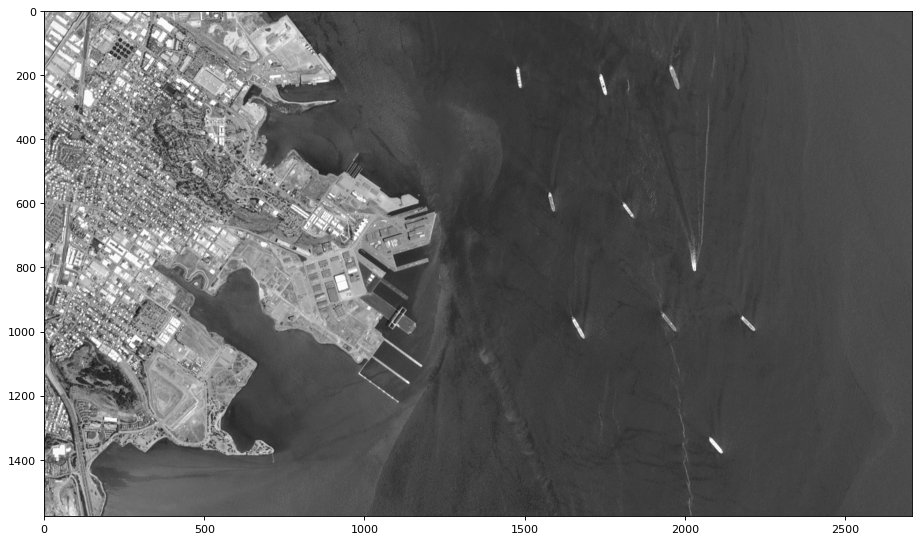

In [32]:
# plt.figure(figsize=(14, 10), dpi=80)
# plt.imshow(gray_img, aspect='auto') 
# plt.imshow(gray_img ,'gray')

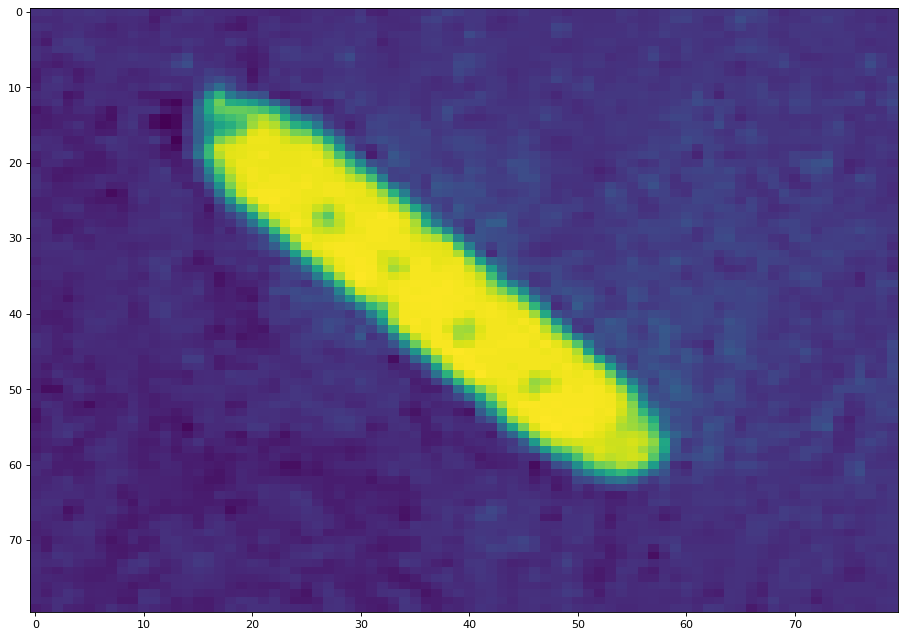

In [44]:
window = gray_img[1320:1400,2060:2140]
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(window, aspect='auto') 
# plt.imshow(gray_img ,'gray')


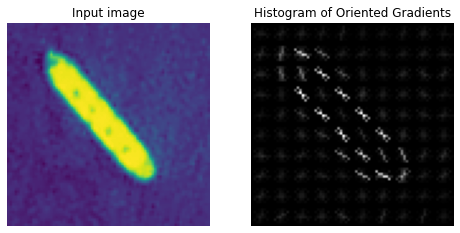

In [55]:

sample_image = np.reshape(X_train[8,0:n*n],(n,n))
fd, hog_image = feature.hog(window, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2,2),transform_sqrt=True, block_norm='L1', visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(window)#, cmap=plt.cm)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10),out_range=(0,255))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


In [89]:
# classifier_model.predict(fd.reshape(1,-1))
# hog, hog_visualisation = image_hog(window)
# #    prediction = classifier_model.predict(hog)
# predict = classifier_model.predict(hog.reshape(1,-1))
# predict
gray_img.shape

(1577, 2709)

In [90]:
n_rows, n_cols = gray_img.shape
window_size = n 
window_stride = 20
found_boxes = []
for y in range(0,n_rows-80, window_stride):
  for x in range(0,n_cols-80, window_stride):
    window = gray_img[y:y+window_size, x:x+window_size]

    hog, hog_visualisation = image_hog(window)
    predict = classifier_model.predict(hog.reshape(1,-1))

    if predict == 1:
      coordinates = [x, y, x + window_size, y + window_size ]
      found_boxes.append(coordinates)




In [92]:
found_boxes = np.array(found_boxes) #.... object detection function output

The non_max_supression function from the imutils package can be used to remove overlapping boxes. The boxes are overlaid on the color version of the satellite image. The function operates on the "found boxes" vector that is output by your object detector.

The overlap threshold can be adjusted, this value determines how much overlap is required before detections are considered to be from the same object. (A high threshold will return more detections)  

Before suppression, we had 45 bounding boxes, after suppression we have 43


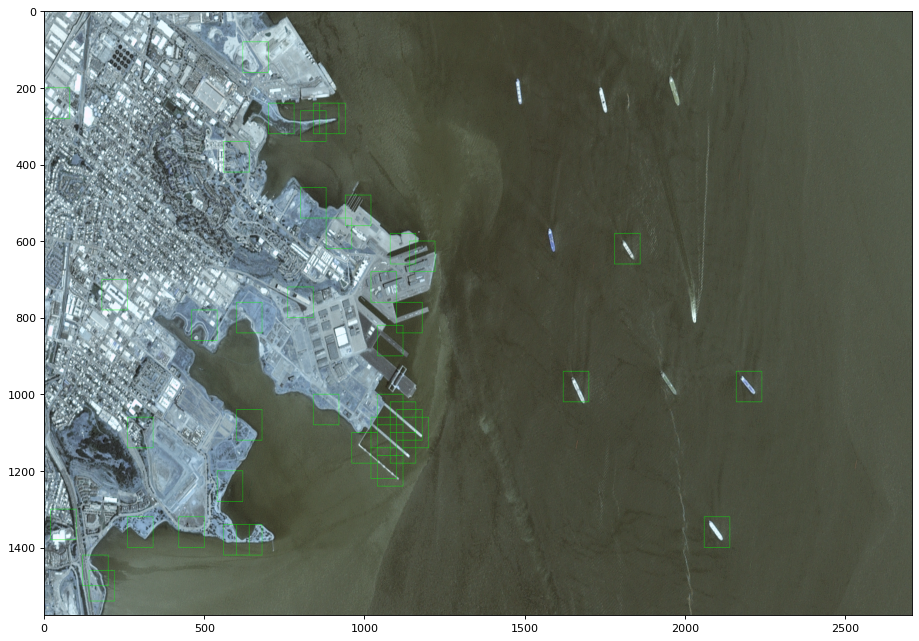

In [93]:
from imutils.object_detection import non_max_suppression

#Bounding box parameters
greenColor = (0, 255, 0)
lineThickness = 4

# run non-max suppression on these based on an overlay op 65%
nmsBoundingBoxes = non_max_suppression(found_boxes, probs=None, overlapThresh=0.65)

print ("Before suppression, we had {} bounding boxes, after suppression we have {}".format(len(found_boxes), len(nmsBoundingBoxes)))

greenColor = (0, 255, 0)
lineThickness = 1
# draw the final bounding boxes
for (xA, yA, xB, yB) in nmsBoundingBoxes:
    cv2.rectangle(col_img, (xA, yA), (xB, yB), greenColor, lineThickness)

# Plot figures
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(col_img, aspect='auto') 
plt.show()